In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import os
import warnings
from scipy.sparse import vstack
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix
import re
from tqdm import tqdm
from collections import Counter
from openai import OpenAI
from sklearn.model_selection import train_test_split
import umap
import ast


In [ ]:


warnings.filterwarnings("ignore")
def aggressive_cleaning(text):
    """
    Cleans the text by handling NaN values and 'nan' strings, normalizing dashes, lowercasing,
    and removing non-alphabetic characters except spaces.
    """
    text = str(text)
    if text.lower() == 'nban' or pd.isna(text):
        return ''
    else:
        text = text.replace('-', ' ').lower().strip()
        text = re.sub(r'[^a-z\s]', '', text)
        return text

def tokenize(text):
    """
    Tokenizes and lemmatizes the given text, applying a word frequency filter.
    Words below the threshold are replaced with 'xxxxx'.
    """
    words = text.split()
    filtered_tokens = [word for word in words if word not in string.punctuation]
    return ' '.join(filtered_tokens)

def preprocess_and_compile_episodes(dataframe):
    """
    Applies preprocessing to the entire DataFrame, then compiles text into episodes,
    with each row corresponding to an episode's aggregated utterances.
    """
    tqdm.pandas(desc="Aggressive cleaning")
    dataframe['utterance'] = dataframe['utterance'].progress_apply(aggressive_cleaning)
    
    tqdm.pandas(desc="Tokenizing")
    dataframe['utterance'] = dataframe['utterance'].progress_apply(tokenize)
    
    tqdm.pandas(desc="Compiling Episodes")
    compiled_episodes = dataframe.groupby('episode')['utterance'].apply(' '.join).reset_index()
    
    return compiled_episodes

episode_df = preprocess_and_compile_episodes(df)
episode_df.to_csv('archive/compiled_episodes.csv', index=False)
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

episode_df['embedding'] = episode_df['utterance'].apply(lambda x: get_embedding(x, model='text-embedding-3-small'))
# save the embeddings as a numpy array
episode_df.to_parquet('archive/episode_embeddings.parquet', compression='snappy')
# save as numpy array
embeddings = np.array(episode_df['embedding'].tolist())
np.save('archive/episode_embeddings.npy', embeddings)

In [6]:
df = pd.read_csv('archive/utterances-2sp.csv')

# save as pandas dataframe
episode_df = pd.read_csv('archive/episode_embeddings.csv')
# Filter the original dataframe to include only rows where 'is_host' is True
hosts_df = df[df['is_host'] == True]

# Since each episode has a single host, we can drop duplicates to avoid repetition
hosts_df = hosts_df[['episode', 'host_id']].drop_duplicates()

# Ensure the 'episode' column is of the same type in both dataframes to avoid merge issues
hosts_df['episode'] = hosts_df['episode'].astype(str)

# Ensure the 'episode' column in embed_df is of type string, matching hosts_df
episode_df['episode'] = episode_df['episode'].astype(str)

# Merge the dataframes on the 'episode' column
embed_df_with_hosts = episode_df.merge(hosts_df, on='episode', how='left')

# Now embed_df_with_hosts contains the embeddings with the corresponding host_id for each episode

embed_df_with_hosts.to_csv('archive/embed_df_with_hosts.csv', index=False)
# select 10 different hosts
host_ids = embed_df_with_hosts['host_id'].unique()[:10]

In [52]:
hosts_df = df[df['is_host'] == True]

# Since each episode has a single host, we can drop duplicates to avoid repetition
hosts_df = hosts_df[['episode', 'host_id']].drop_duplicates()

host_ids = hosts_df['host_id'].unique()[:10]

len(host_ids)

10

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=750)
plt.scatter(*embedding.T, s=1, c=y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title('UMAP projection of the embeddings', fontsize=18)
# add colorbar
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_label('Host ID', rotation=270)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(host_ids)
plt.show()

In [25]:
# Convert the string into a list and then into an array of floats
embed_df_with_hosts['embedding'] = embed_df_with_hosts['embedding'].apply(lambda x: np.array(ast.literal_eval(x)))

embed_df_with_hosts.info()

# save as df
embed_df_with_hosts.to_csv('archive/embed_df_with_hosts.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23714 entries, 0 to 23713
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   episode    23714 non-null  object 
 1   utterance  23714 non-null  object 
 2   embedding  23714 non-null  object 
 3   host_id    23447 non-null  float64
dtypes: float64(1), object(3)
memory usage: 741.2+ KB


In [54]:
# filter the dataframe to include only the selected hosts
my_df = embed_df_with_hosts[embed_df_with_hosts['host_id'].isin(host_ids)]
X, y = my_df['embedding'].values, my_df['host_id'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Convert the lists of floats into numpy arrays
X_train = np.array([np.array(x) for x in X_train])
X_test = np.array([np.array(x) for x in X_test])


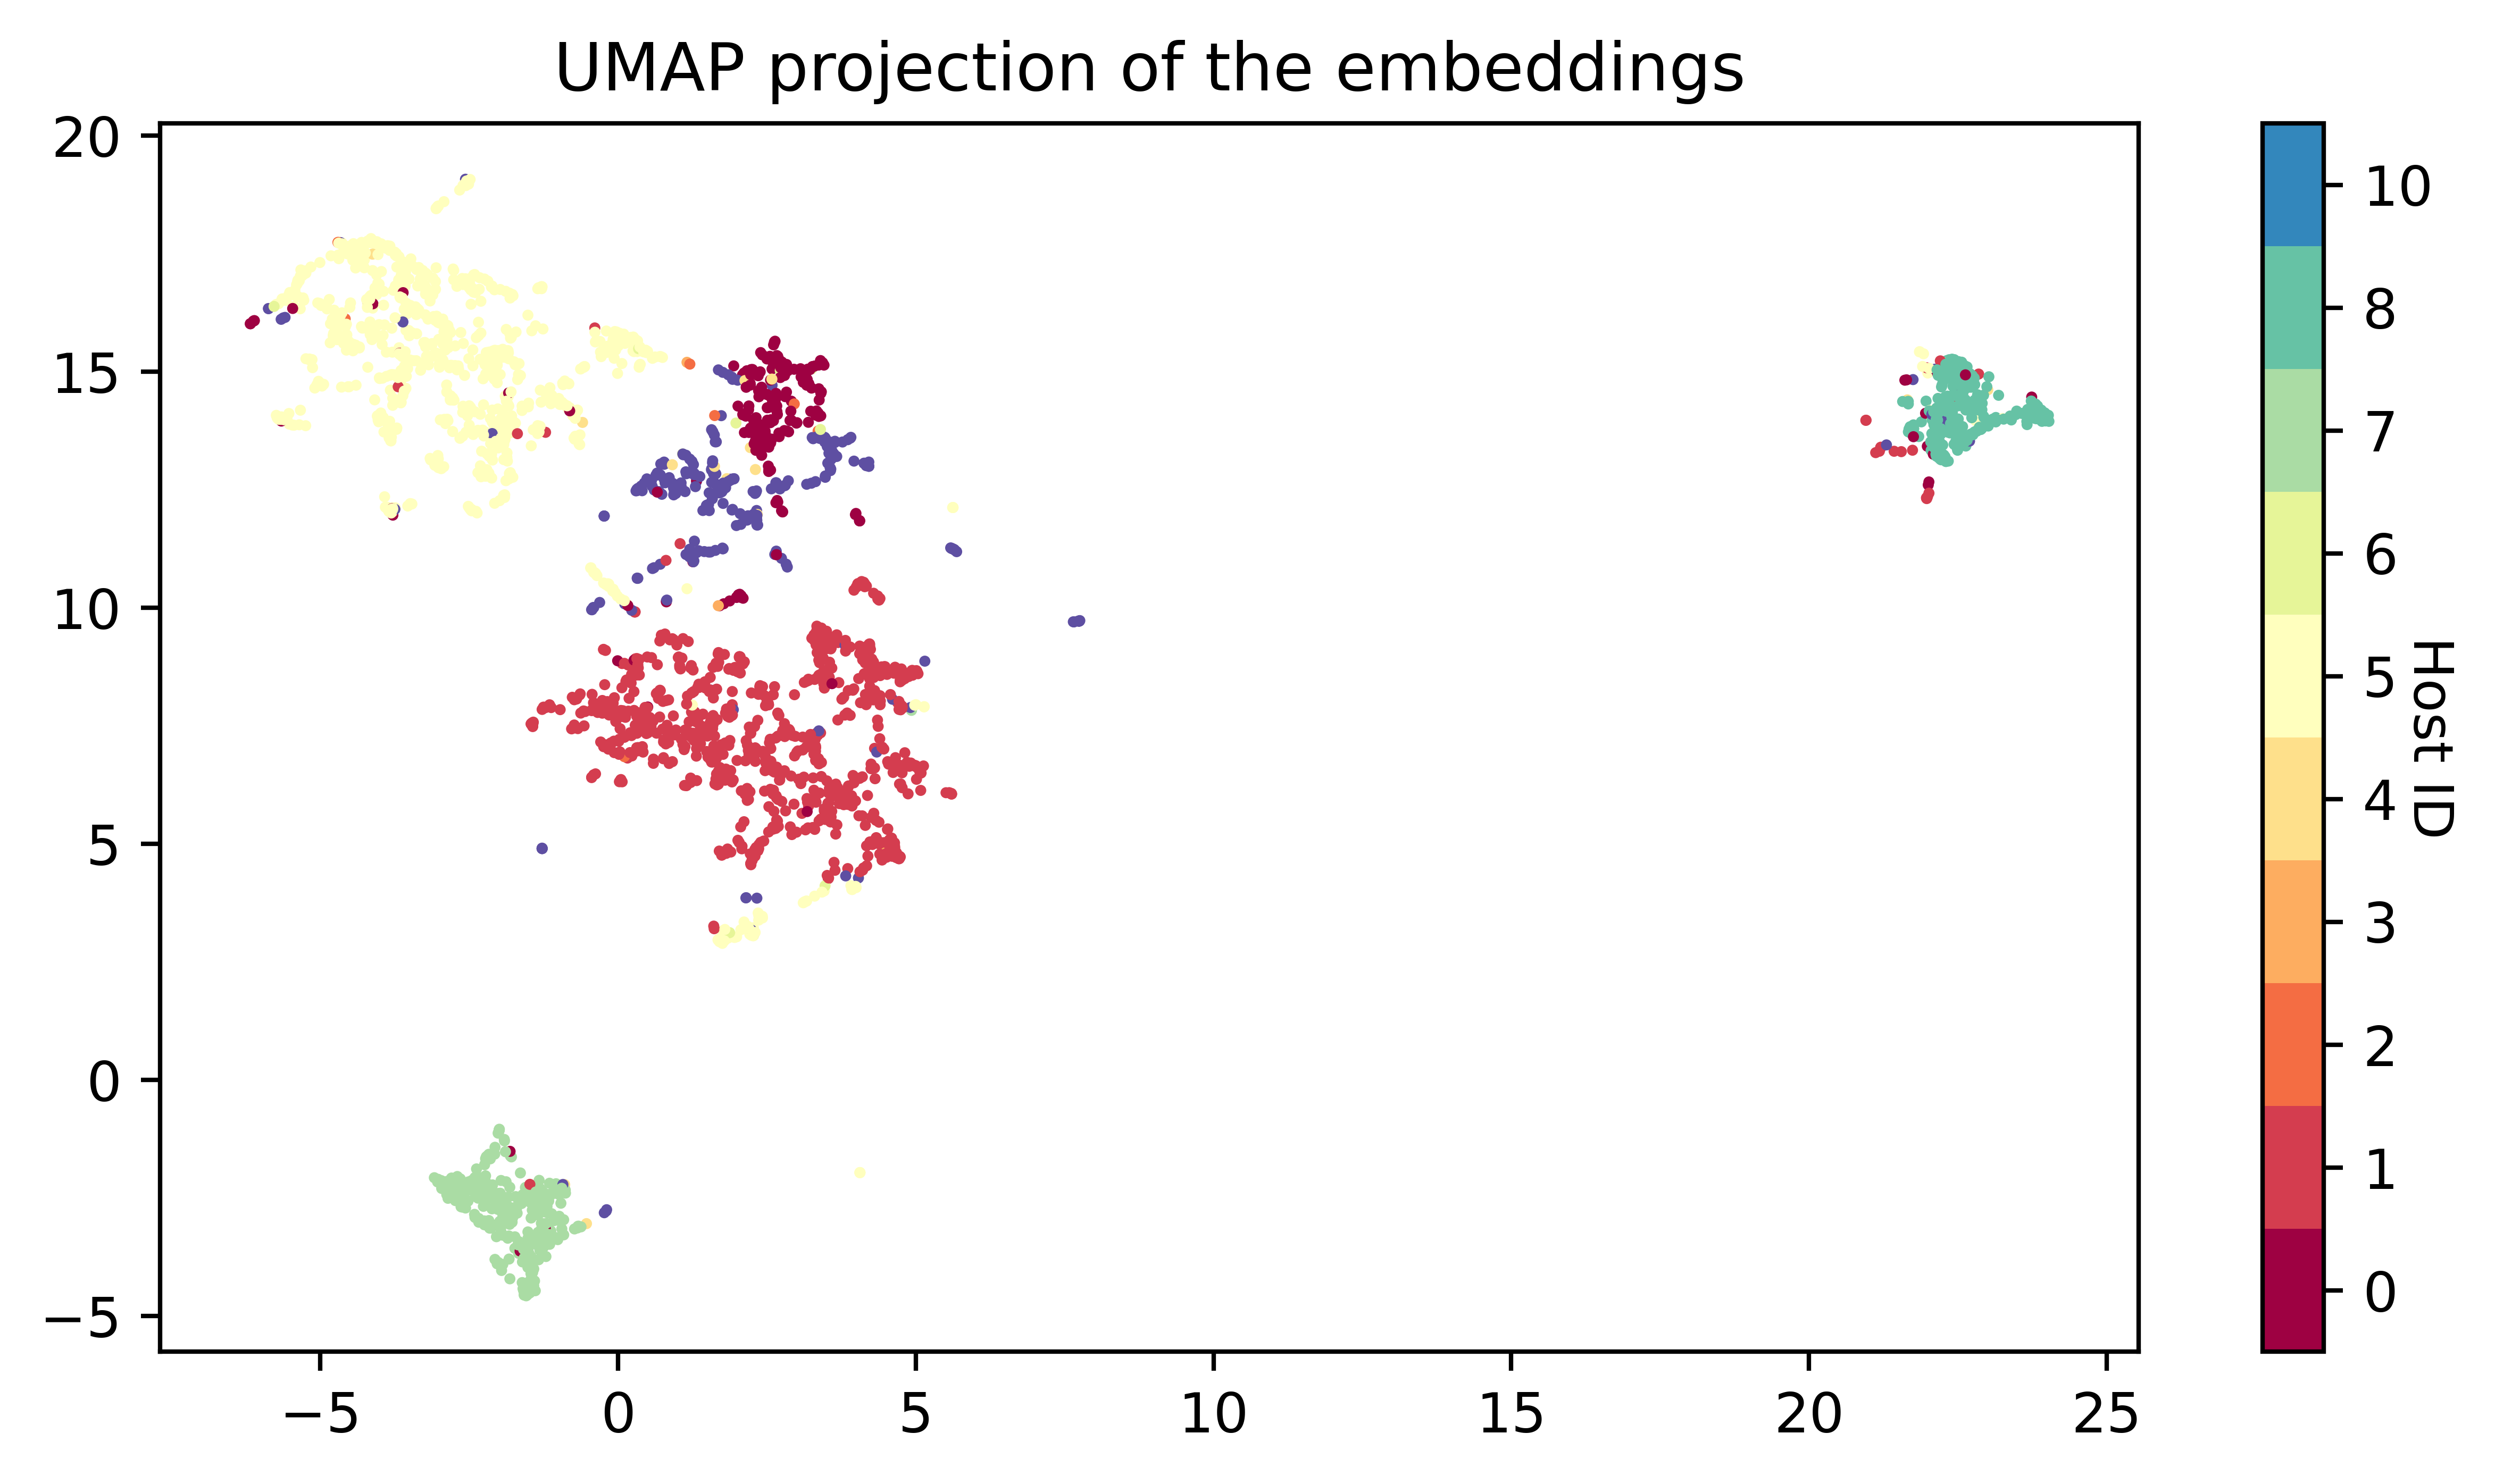

In [57]:
# embedding = umap.UMAP().fit_transform(X_train, y_train)
plt.figure(figsize=(8, 4), dpi=750)
plt.scatter(*embedding.T, s=1, c=y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title('UMAP projection of the embeddings')
# add colorbar
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_label('Host ID', rotation=270)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(host_ids)
plt.show()

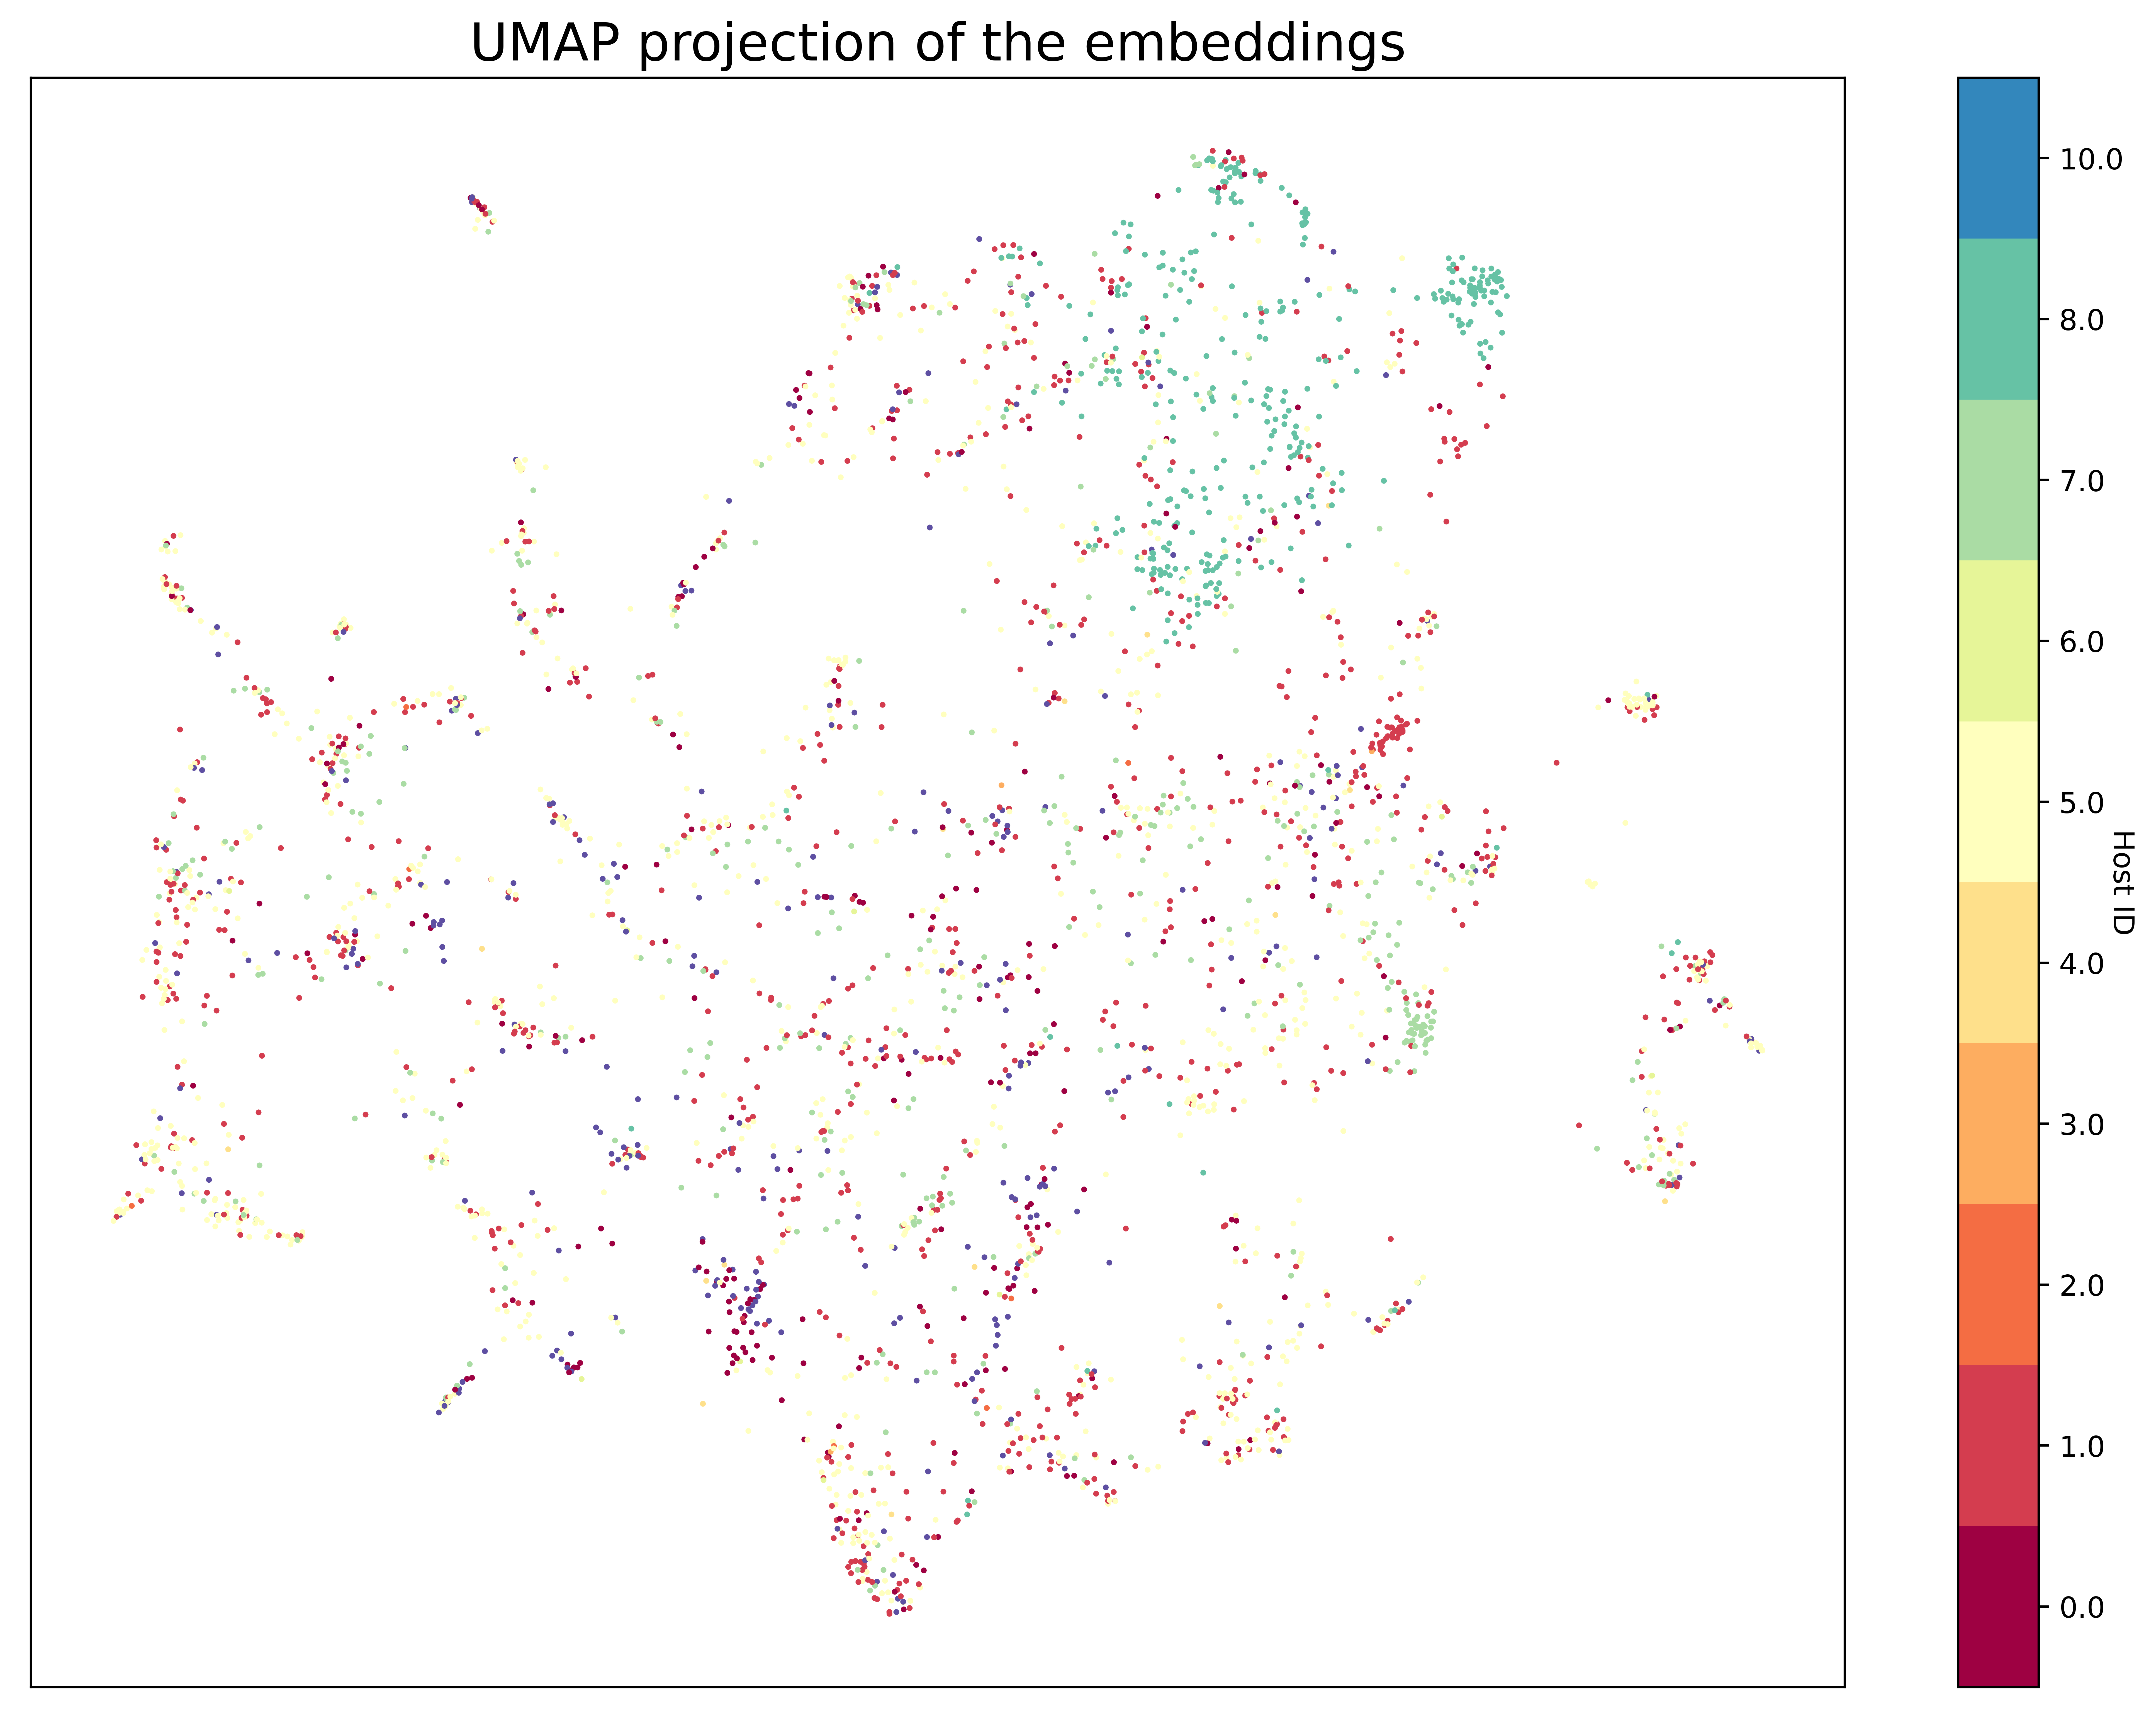

In [32]:
embedding = umap.UMAP().fit_transform(X_train)
fig, ax = plt.subplots(1, figsize=(14, 10), dpi=750)
plt.scatter(*embedding.T, s=1, c=y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title('UMAP projection of the embeddings', fontsize=18)
# add colorbar
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_label('Host ID', rotation=270)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(host_ids)
plt.show()

In [36]:
# number of hosts
len(host_ids)

117

In [42]:
X, y = embed_df_with_hosts['embedding'].values, embed_df_with_hosts['host_id'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Convert the lists of floats into numpy arrays
X_train = np.array([np.array(x) for x in X_train])
X_test = np.array([np.array(x) for x in X_test])
# Reduce dimensions to 20 with UMAP
umap_reducer = umap.UMAP(n_components=20)
X_reduced = umap_reducer.fit_transform(X_train)

# Step 2: Fit a GMM to the reduced data
# Choose the number of components based on domain knowledge or experimentation
n_components = len(host_ids)
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X_reduced)

# Predict cluster labels
cluster_labels = gmm.predict(X_reduced)

/var/folders/6r/hg6ljwj9053_dvzxcp0nfzsm0000gn/T/ipykernel_21430/3015647028.py:7: RuntimeWarning: invalid value encountered in cast
  y_train = y_train.astype(int)
/var/folders/6r/hg6ljwj9053_dvzxcp0nfzsm0000gn/T/ipykernel_21430/3015647028.py:8: RuntimeWarning: invalid value encountered in cast
  y_test = y_test.astype(int)


In [ ]:
def filter_episodes(df, cluster_label